<a href="https://colab.research.google.com/github/darkha03/Introduction_to_Machine_Learning/blob/main/TP2_%E2%80%94_Introduction_aux_CNN_sur_Fashion_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP2 — Introduction aux CNN sur Fashion-MNIST (3h)

**Module : Deep Learning & applications — 4A STI**  
**Durée : 3h**

## Objectifs
- Comprendre la **convolution** (filtres, feature maps)
- Comprendre le rôle de **ReLU** et **MaxPooling**
- Construire et entraîner un **CNN** simple sur **Fashion-MNIST** (PyTorch)
- Vérifier les **shapes**, compter les **paramètres**, suivre **loss** et **accuracy**

## Règles
Autorisé : `numpy`, `matplotlib`, `torch`, `torchvision`  

## À rendre
- le notebook complété (toutes les cellules exécutables)
- figures demandées (loss, accuracy, confusion matrix)
- réponses aux questions (en Markdown)

## 0) Imports et configuration

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

torch.manual_seed(0)
np.random.seed(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## 1) Chargement du dataset et visualisation

### Travail demandé
1. Charger Fashion-MNIST (train + test)
2. Afficher 8 images + labels
3. Vérifier les shapes (image et batch)

100%|██████████| 26.4M/26.4M [00:01<00:00, 13.8MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 203kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.78MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 25.6MB/s]


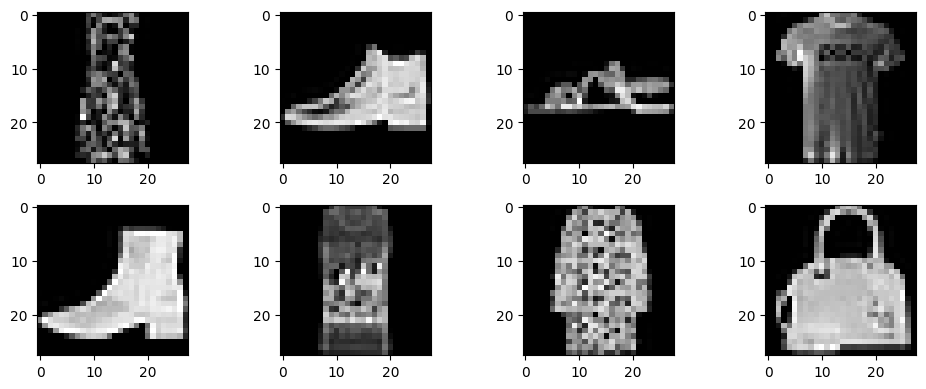

Image shape: torch.Size([1, 28, 28])
Batch shape: torch.Size([128, 1, 28, 28])


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    # TODO: normalisation (avec mean=0.5, std=0.5)
    transforms.Normalize(mean=0.5, std=0.5)
])

train_ds = datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform)
test_ds  = datasets.FashionMNIST(root="./data", train=False, download=True, transform=transform)

class_names = [
    "T-shirt/top","Trouser","Pullover","Dress","Coat",
    "Sandal","Shirt","Sneaker","Bag","Ankle boot"
]

# TODO: DataLoaders, shuffle=True for train_loader
batch_size = 128
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

# Inverser la normalisation pour la visualisation de l'image
def denorm(x, mean=0.5, std=0.5):
    return x * std + mean

imgs, labels = next(iter(train_loader))

plt.figure(figsize=(10,4))
for i in range(8):
    plt.subplot(2,4,i+1)
    img = denorm(imgs[i]).squeeze(0).numpy()
    plt.imshow(img, cmap="gray")

plt.tight_layout()
plt.show()

print("Image shape:", imgs[0].shape)  # (1, 28, 28)
print("Batch shape:", imgs.shape)     # (B, 1, 28, 28)

# Partie A — Convolution “à la main” (NumPy) (~45 min)

On implémente une convolution 2D **valid** (sans padding), stride 1.
- Entrée : X (H, W)
- Filtre : K (kH, kW)
- Sortie : (H-kH+1, W-kW+1)

Valeur : Y[i,j] = somme(X patch * K)

## 2) Implémenter une convolution 2D (valid)
###  Formule mathématique de la convolution (valid, stride = 1)

Soit :

- $X \in \mathbb{R}^{H \times W}$ l’image d’entrée  
- $K \in \mathbb{R}^{kH \times kW}$ le filtre (kernel)  
- $Y \in \mathbb{R}^{(H-kH+1) \times (W-kW+1)}$ la sortie  

La convolution **valid** est définie par :

$$
Y[i,j] =
\sum_{u=0}^{kH-1}
\sum_{v=0}^{kW-1}
X[i+u,\, j+v] \cdot K[u,v]
$$

pour :

$$
0 \le i < H-kH+1,
\qquad
0 \le j < W-kW+1
$$

---

###  Interprétation

1. On extrait un **patch** de l’image :

$$
X[i:i+kH,\; j:j+kW]
$$

2. On multiplie élément par élément avec le filtre $K$

3. On somme toutes les valeurs pour obtenir $Y[i,j]$





In [ ]:

def conv2d_valid(X, K):
    """
    X: np.array (H, W)
    K: np.array (kH, kW)
    return: np.array (H-kH+1, W-kW+1)
    """
    H, W = X.shape
    kH, kW = K.shape
    out_h = H - kH + 1
    out_w = W - kW + 1

    # TODO
    Y = np.zeros((out_h, out_w))

    for i in range(out_h):
        for j in range(out_w):
            patch = X[i:i+kH, j:j+kW]
            Y[i, j] = np.sum(patch * K)

    return Y

## 3) Appliquer des filtres sur une image Fashion-MNIST

### Filtres utilisés

#### 🟢 Filtre Sobel (Sobel X)

Le filtre **Sobel** est un filtre de détection de contours. Il approxime la dérivée de l’image dans une direction (ici horizontale).

Il met en évidence les **variations brusques d’intensité** (bords).

Exemple (Sobel X) :

$$
\begin{bmatrix}
-1 & 0 & 1 \\
-2 & 0 & 2 \\
-1 & 0 & 1
\end{bmatrix}
$$

→ Détecte principalement les **contours verticaux**.

---

#### 🔵 Filtre Blur (flou)

Le filtre **blur** est un filtre de lissage.

Il remplace chaque pixel par la **moyenne locale** des pixels voisins.

Exemple :

$$
\frac{1}{9}
\begin{bmatrix}
1 & 1 & 1 \\
1 & 1 & 1 \\
1 & 1 & 1
\end{bmatrix}
$$

→ Réduit le bruit  
→ Rend l’image plus floue  
→ Supprime les détails fins

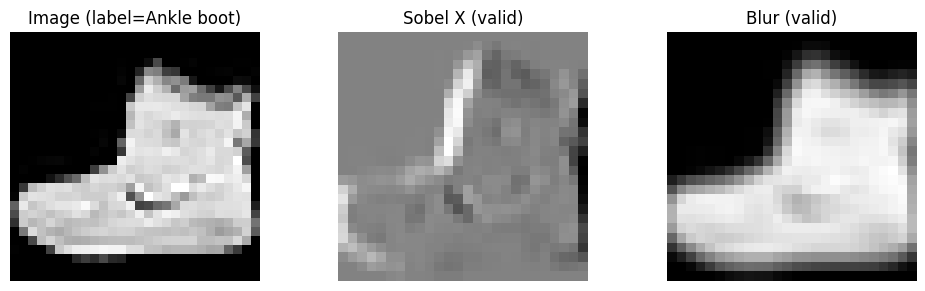

img0: (28, 28) feat_sobel: (26, 26) feat_blur: (26, 26)


In [ ]:

# Image brute (sans normalisation) pour la conv NumPy
raw_ds = datasets.FashionMNIST(root="./data", train=True, download=True, transform=transforms.ToTensor())
img_t, y0 = raw_ds[0]
img0 = img_t.squeeze(0).numpy()  # (28, 28)

sobel_x = np.array([[-1,0,1],[-2,0,2],[-1,0,1]], dtype=np.float32)
blur = (1/9) * np.ones((3,3), dtype=np.float32)

# TODO
feat_sobel = conv2d_valid(img0, sobel_x)
feat_blur  = conv2d_valid(img0, blur)

plt.figure(figsize=(10,3))
plt.subplot(1,3,1); plt.imshow(img0, cmap="gray"); plt.title(f"Image (label={class_names[y0]})"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(feat_sobel, cmap="gray"); plt.title("Sobel X (valid)"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(feat_blur, cmap="gray"); plt.title("Blur (valid)"); plt.axis("off")
plt.tight_layout()
plt.show()

print("img0:", img0.shape, "feat_sobel:", feat_sobel.shape, "feat_blur:", feat_blur.shape)

## 4) Questions (Markdown)
1. Que fait un filtre de convolution ?
- Un filtre de convolution sert à scanner une zone de taille plus petite pour des détail
2. Pourquoi une convolution utilise beaucoup moins de paramètres qu’une couche fully-connected appliquée à une image ?
- Car une convolution s'appuie sur que une petite partie de données donc les paramètres sont beaucoup plus moins
3. Que se passe-t-il si on augmente la taille du filtre (ex : 5×5 au lieu de 3×3) ? Quel impact sur :

    - la taille de sortie ?
      la taille de sortie diminue car le filtre est grand donc il peut capturer plus d'information .

    - la quantité d’information locale capturée ?
      Il peut capturer plus d'information locale qui permet de détecter la relation entre les pixels éloignés.

# Partie B — CNN PyTorch

Exemple d'une architecture CNN :

<p align="center">
  <img src="cnn.webp" width="1200">
</p>

## **Architecture proposée :**
- Conv2d(1→16, kernel=3, padding=1) + ReLU + MaxPool2d(2)
- Conv2d(16→32, kernel=3, padding=1) + ReLU + MaxPool2d(2)
- Flatten
- Linear(32 * 7 * 7 → 10)

## 5) Compléter le modèle CNN

In [ ]:

class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool  = nn.MaxPool2d(kernel_size=2)
        self.fc    = nn.Linear(64 * 3 * 3, 10)

    def forward(self, x):
        # TODO: conv1 -> relu -> pool
        x = self.pool(F.relu(self.conv1(x)))
        # TODO: conv2 -> relu -> pool
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # TODO: flatten
        x = torch.flatten(x, start_dim=1)
        # TODO: fc
        x = self.fc(x)
        return x

model = SimpleCNN().to(device)

xb, yb = next(iter(train_loader))
xb = xb.to(device)
logits = model(xb)
print("Input:", xb.shape)
print("Logits:", logits.shape)  # (B, 10)

Input: torch.Size([128, 1, 28, 28])
Logits: torch.Size([128, 10])


## 6) Entraînement et évaluation

In [ ]:

criterion = nn.CrossEntropyLoss()
# TODO: optimiseur
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def train_one_epoch(model, loader):
    model.train()
    total_loss, correct, total = 0.0, 0, 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)

        # TODO
        logits = model(x)
        loss = criterion(logits, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        pred = logits.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += x.size(0)

    return total_loss/total, correct/total

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)

        # TODO
        logits = model(x)
        loss = criterion(logits, y)

        total_loss += loss.item() * x.size(0)
        pred = logits.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += x.size(0)

    return total_loss/total, correct/total

## 7) Lancer l'entraînement (5 epochs)

Essayez d'abord avec 5 epochs et puis augmentez le nombre d'épochs

In [ ]:
epochs = 20
train_losses, train_accs = [], []
test_losses, test_accs = [], []

for ep in range(1, epochs+1):
    # entrainement du modèle
    tr_loss, tr_acc = train_one_epoch(model, train_loader)
    # evaluation après chaque itération avec les données de test
    te_loss, te_acc = evaluate(model, test_loader)

    train_losses.append(tr_loss); train_accs.append(tr_acc)
    test_losses.append(te_loss); test_accs.append(te_acc)

    print(f"Epoch {ep}/{epochs} | train loss {tr_loss:.4f} acc {tr_acc:.3f} | test loss {te_loss:.4f} acc {te_acc:.3f}")

Epoch 1/40 | train loss 0.5898 acc 0.795 | test loss 0.4018 acc 0.857
Epoch 2/40 | train loss 0.3519 acc 0.873 | test loss 0.3449 acc 0.874
Epoch 3/40 | train loss 0.3005 acc 0.891 | test loss 0.3135 acc 0.887
Epoch 4/40 | train loss 0.2725 acc 0.901 | test loss 0.3062 acc 0.886
Epoch 5/40 | train loss 0.2553 acc 0.908 | test loss 0.2954 acc 0.893
Epoch 6/40 | train loss 0.2416 acc 0.912 | test loss 0.2777 acc 0.899
Epoch 7/40 | train loss 0.2277 acc 0.917 | test loss 0.2809 acc 0.900
Epoch 8/40 | train loss 0.2151 acc 0.921 | test loss 0.2769 acc 0.901
Epoch 9/40 | train loss 0.2043 acc 0.925 | test loss 0.2795 acc 0.903
Epoch 10/40 | train loss 0.1950 acc 0.928 | test loss 0.2716 acc 0.902
Epoch 11/40 | train loss 0.1853 acc 0.932 | test loss 0.2635 acc 0.909
Epoch 12/40 | train loss 0.1773 acc 0.935 | test loss 0.2748 acc 0.905
Epoch 13/40 | train loss 0.1697 acc 0.938 | test loss 0.2609 acc 0.909
Epoch 14/40 | train loss 0.1614 acc 0.941 | test loss 0.2646 acc 0.908
Epoch 15/40 | t

KeyboardInterrupt: 

## 8) Courbes loss / accuracy

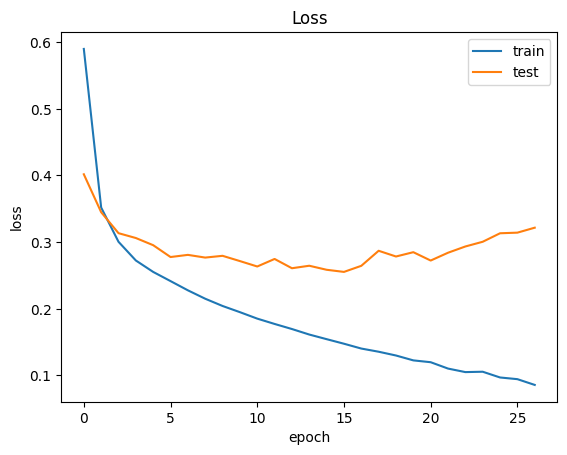

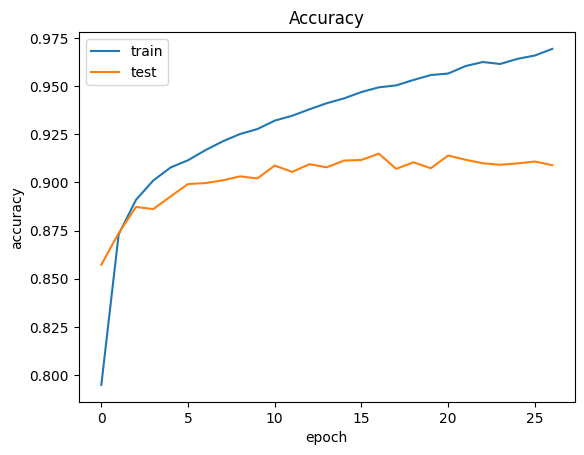

In [ ]:
plt.figure()
plt.plot(train_losses, label="train")
plt.plot(test_losses, label="test")
plt.xlabel("epoch"); plt.ylabel("loss"); plt.title("Loss"); plt.legend()
plt.show()

plt.figure()
plt.plot(train_accs, label="train")
plt.plot(test_accs, label="test")
plt.xlabel("epoch"); plt.ylabel("accuracy"); plt.title("Accuracy"); plt.legend()
plt.show()

# Partie C — Analyse

## 9) Nombre de paramètres

In [ ]:

def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Total params:", count_params(model))

Total params: 29066


## 10) Bonus : visualiser les filtres appris (conv1)

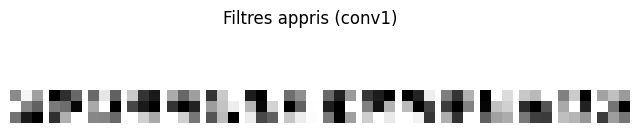

In [ ]:

with torch.no_grad():
    W = model.conv1.weight.detach().cpu()  # (out_channels, in_channels, kH, kW)
    plt.figure(figsize=(8,2))
    for i in range(W.shape[0]):
        plt.subplot(1, W.shape[0], i+1)
        plt.imshow(W[i,0], cmap="gray")
        plt.axis("off")
    plt.suptitle("Filtres appris (conv1)")
    plt.show()

## 11) Questions (Markdown)
1. Intérêt du partage de poids ?
- Pour réduire les paramètres qui permet le modèle d'apprendre plus vite
2. Pourquoi pooling ?
- Pour diminuer la dimension à fin de voir les détails plus fin et éviter l'overfitting
3. Pourquoi CNN > MLP pour images ?
- Car CNN est optimisé pour le traitement d'images avec des couches spécifiées comme Convo2D et Pooling
4. Quel hyperparamètre a le plus d’impact (lr, filtres, epochs) ?
- lr a le plus d'impact car si le lr est trop grand le modèle peut skipper le point optimal mais s'il est trop petit, le modèle apprend lentement et il est possible de ne jamais passer le point optimal local

### Bonus
- Doubler les filtres (32, 64) et observer.
- Ajouter un Dropout après flatten. Qu'est ce que vous remarquez ?